In [50]:
## IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [85]:
# Path of the file to read
NYC_File_Path = 'nyc-rolling-sales.csv'

# Data Cleaning
home_data = pd.read_csv(NYC_File_Path)
home_data = home_data.dropna(axis=0)
home_data = home_data[home_data['LAND SQUARE FEET'] != ' -  ']
home_data = home_data[home_data['SALE PRICE'] != ' -  ']
home_data = home_data[home_data['GROSS SQUARE FEET'] != ' -  ']

# Adding integer type columns
sale_price = pd.to_numeric(home_data['SALE PRICE'], errors='coerce')
land_square_feet = pd.to_numeric(home_data['LAND SQUARE FEET'], errors='coerce')
gross_square_feet = pd.to_numeric(home_data['GROSS SQUARE FEET'], errors='coerce')
home_data['sale_price_int'] = sale_price
home_data['land_square_feet_int'] = land_square_feet
home_data['gross_square_feet_int'] = gross_square_feet

# Removing values of transactions less than $ 1000 (not reflective of true value)
home_data = home_data[home_data['sale_price_int'] > 1000] # removing nonsense values
home_data = home_data[home_data['sale_price_int'] < 1000000]
home_data.to_csv('nyc-rolling-sales-cleaned.csv')

# Create target object and call it y
y = home_data.sale_price_int
max_price = max(y)
avg_price = y.mean()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,sale_price_int,land_square_feet_int,gross_square_feet_int
223,227,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2B,765,25,,C4,219 WEST 15TH STREET,...,1566,6330,1901,2,C4,416790,2017-08-31 00:00:00,416790,1566,6330
224,228,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2B,765,25,,C4,219 WEST 15TH STREET,...,1566,6330,1901,2,C4,630370,2017-08-31 00:00:00,630370,1566,6330
277,281,1,CHELSEA,09 COOPS - WALKUP APARTMENTS,2,744,32,,C6,309 WEST 20TH STREET,...,4600,12200,1850,2,C6,282000,2016-10-19 00:00:00,282000,4600,12200
2062,2066,1,FASHION,23 LOFT BUILDINGS,4,805,39,,L1,115-123 W 29TH,...,6994,79465,1913,4,L1,220000,2016-12-19 00:00:00,220000,6994,79465
2587,2591,1,FLATIRON,08 RENTALS - ELEVATOR APARTMENTS,2,844,8,,D6,9 EAST 16TH STREET,...,4600,30680,1900,2,D6,489854,2017-01-27 00:00:00,489854,4600,30680


In [73]:
# Create X - Choosing features I think would be most influential
features = ['RESIDENTIAL UNITS','COMMERCIAL UNITS', 'TOTAL UNITS', 'land_square_feet_int',
       'gross_square_feet_int','BOROUGH','TAX CLASS AT TIME OF SALE','ZIP CODE','YEAR BUILT']
X = home_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1,test_size=0.2)
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
candidate_max_leaf_nodes = list(range(2,500))
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
leaf = []
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

for index,n in enumerate(candidate_max_leaf_nodes):
    k = get_mae(n, train_X, val_X, train_y, val_y)
    leaf.append(k) 
# Store the best value of max_leaf_nodes 
best_tree_size = candidate_max_leaf_nodes[leaf.index(min(leaf))]
print(best_tree_size)

# Specify Model
home_model = DecisionTreeRegressor(random_state=0,max_leaf_nodes=best_tree_size)

# Fit Model
home_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = home_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE specifying max leaf nodes {}".format(val_mae))

(23086, 9) (23086,)
(5772, 9) (5772,)
370
Validation MSE specifying max leaf nodes 133046.79200907535


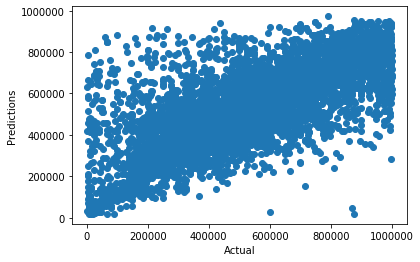

Validation MSE for Random Forest Model: 127143.65969621109
0.24173005693470492


In [74]:
## RANDOM FOREST
# Define the model

rf_model = RandomForestRegressor(random_state=0,n_estimators=200)

# fit model
rf_model.fit(train_X,train_y)

# Calculate the mean absolute error of Random Forest model on the validation data
val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(val_predictions, val_y)

plt.scatter(val_y,val_predictions)
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.show()
print("Validation MSE for Random Forest Model: {}".format(rf_val_mae))
print(rf_val_mae/avg_price)

In [78]:
# RIDGE
l = list(range(7000,10000))
home_model_CV = RidgeCV(alphas=l)
home_model = home_model_CV.fit(train_X,train_y)
print(home_model.alpha_)
val_predictions = home_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)

9999
Validation MSE 200623.06081774738
0.38143171299114376


In [83]:
#LASSO
home_model_CV = LassoCV(alphas=[3398,1],cv=5)
home_model = home_model_CV.fit(train_X,train_y)
print(home_model.alpha_)
val_predictions=home_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)

3398
Validation MSE 200004.55623576415
0.3802557900377349


/Users/kevinmartin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520770821278979.06, tolerance: 108819075300.77757
  tol, rng, random, positive)
/Users/kevinmartin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521135806651731.2, tolerance: 109013154148.02646
  tol, rng, random, positive)
/Users/kevinmartin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521214984428215.4, tolerance: 109329805785.92184
  tol, rng, random, positive)
/Users/kevinmartin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: 

In [84]:
lm = linear_model.LinearRegression()
model = lm.fit(train_X, train_y)
val_predictions = lm.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MSE {}".format(val_mae))
print(val_mae/avg_price)

Validation MSE 198941.90592344553
0.37823544139343585


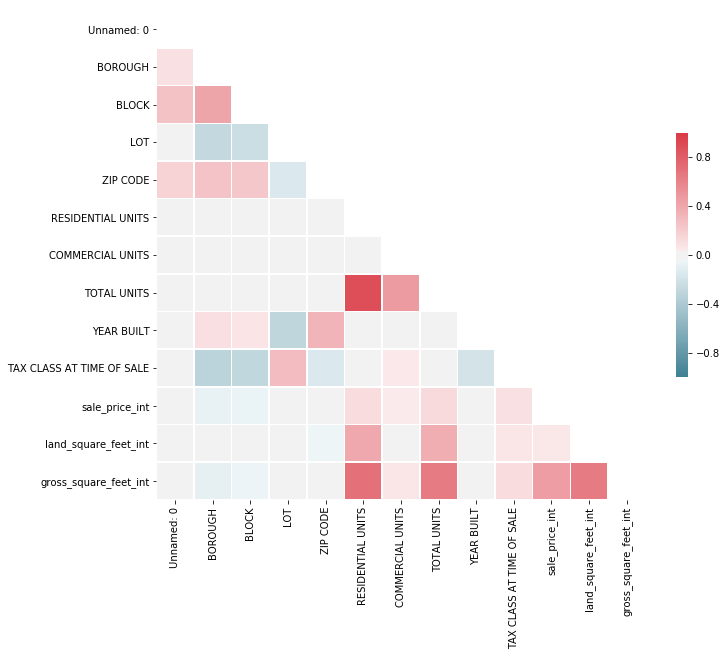

In [15]:
## CORRELATION MATRIX
corr = home_data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
sns.pairplot(train_data)